In [1]:
# 分组变换和分析
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import string
import tushare as ts # Yahoo的接口不能指望了
from pandas import DataFrame, Series
from pandas.tseries.offsets import Day, Hour, Minute, MonthEnd
from sklearn.linear_model import LinearRegression

%matplotlib inline

In [2]:
N = 1000
def rands(n):
  choices = string.ascii_uppercase
  return ''.join([random.choice(choices) for _ in range(n)])
tickers = np.array([rands(5) for _ in range(N)])
tickers[:10] # 随机生成1000个股票代码，显示前10个。

array(['MQNCX', 'IJYOS', 'CTAMU', 'DAANV', 'PAQJB', 'FBHXO', 'NRXGH',
       'BBTFB', 'WEZHG', 'VSJOL'],
      dtype='<U5')

In [3]:
M = 500
df = DataFrame({'Momentum' : np.random.randn(M) / 200 + 0.03,
                'Value' : np.random.randn(M) / 200 + 0.08,
                'ShortInterest' : np.random.randn(M) / 200 - 0.02},
               index=tickers[:M])
df.head()

,Momentum,ShortInterest,Value
MQNCX,0.033327,-0.022390,0.080698
IJYOS,0.045715,-0.018835,0.093913
CTAMU,0.030443,-0.014324,0.073361
DAANV,0.021882,-0.012971,0.079016
PAQJB,0.030116,-0.025061,0.079561


In [4]:
ind_names = np.array(['FINANCIAL', 'TECH'])
sampler = np.random.randint(0, len(ind_names), N)
industries = Series(ind_names[sampler],
                    index=tickers,
                    name='industry')
industries.head() # 随机给公司分类，financial或tech。

MQNCX         TECH
IJYOS    FINANCIAL
CTAMU         TECH
DAANV         TECH
PAQJB         TECH
Name: industry, dtype: object

In [5]:
by_industry = df.groupby(industries)
by_industry.mean() # 计算按行业分组的平均值

,Momentum,ShortInterest,Value
industry,,,
FINANCIAL,0.030235,-0.020340,0.079965
TECH,0.030338,-0.019692,0.079927


In [6]:
by_industry.describe()

Momentum                                                    \
             count      mean       std       min       25%       50%   
industry                                                               
FINANCIAL    230.0  0.030235  0.004861  0.018799  0.027297  0.029913   
TECH         270.0  0.030338  0.004785  0.017966  0.027037  0.030376   

                              ShortInterest              ...               \
                75%       max         count      mean    ...          75%   
industry                                                 ...                
FINANCIAL  0.032982  0.046882         230.0 -0.020340    ...    -0.017302   
TECH       0.033564  0.043232         270.0 -0.019692    ...    -0.016145   

                     Value                                                    \
                max  count      mean       std       min       25%       50%   
industry                                                                       
FINANCIAL -0.006896  230.0  0.079965  0.005032  0.064342  0.076482  0.079450   
TECH      -0.004464  270.0  0.079927  0.005413  0.059576  0.076253  0.079672   

                               
                75%       max  
industry                       
FINANCIAL  0.083322  0.094006  
TECH       0.083438  0.093884  

[2 rows x 24 columns]

In [7]:
def zscore(group):
  return (group - group.mean()) / group.std()

In [8]:
df_stand = by_industry.apply(zscore) # 每个股票减去所在分组的平均值再除标准差
df_stand.head()

,Momentum,ShortInterest,Value
MQNCX,0.624594,-0.539440,0.142331
IJYOS,3.184773,0.314931,2.771779
CTAMU,0.021955,1.073453,-1.212983
DAANV,-1.767286,1.344028,-0.168335
PAQJB,-0.046455,-1.073684,-0.067583


In [9]:
df_stand.groupby(industries).agg(['mean', 'std']) # 显然均值为0，标准差为1。看下zscore公式就明白了。

Momentum      ShortInterest              Value     
                   mean  std          mean  std          mean  std
industry                                                          
FINANCIAL  4.962818e-16  1.0  2.280302e-15  1.0  1.915316e-14  1.0
TECH       7.822960e-16  1.0 -1.085551e-16  1.0 -2.607970e-15  1.0

In [10]:
ind_rank = by_industry.rank(ascending=False)
ind_rank.head()

,Momentum,ShortInterest,Value
MQNCX,76.0,188.0,114.0
IJYOS,2.0,84.0,2.0
CTAMU,134.0,38.0,243.0
DAANV,260.0,25.0,152.0
PAQJB,143.0,234.0,142.0


In [11]:
ind_rank.groupby(industries).agg(['min', 'max'])

Momentum        ShortInterest        Value       
               min    max           min    max   min    max
industry                                                   
FINANCIAL      1.0  230.0           1.0  230.0   1.0  230.0
TECH           1.0  270.0           1.0  270.0   1.0  270.0

In [12]:
by_industry.apply(lambda x: zscore(x.rank())).head() # 标准化排名数据

,Momentum,ShortInterest,Value
MQNCX,0.761976,-0.672331,0.275336
IJYOS,1.705755,0.473403,1.705755
CTAMU,0.019209,1.248615,-1.376679
DAANV,-1.594386,1.415098,-0.211304
PAQJB,-0.096047,-1.261422,-0.083241


In [13]:
# 分组因子暴露

In [14]:
fac1, fac2, fac3 = np.random.rand(3, 1000)
ticker_subset = tickers.take(np.random.permutation(N)[:1000])
ticker_subset[:10]

array(['DMIQP', 'VZJDZ', 'JZISA', 'BRGLD', 'MNRHS', 'PPCPE', 'KWSMF',
       'NHPNA', 'ZTUMI', 'BNBRW'],
      dtype='<U5')

In [15]:
port = Series(0.7 * fac1 - 1.2 * fac2 + 0.3 * fac3 + np.random.rand(1000),
              index=ticker_subset)
port.head()

DMIQP    0.489926
VZJDZ    1.183795
JZISA    0.866891
BRGLD    0.316336
MNRHS    0.132618
dtype: float64

In [16]:
factors = DataFrame({'f1': fac1, 'f2': fac2, 'f3': fac3},
                    index=ticker_subset)
factors.head()

,f1,f2,f3
DMIQP,0.149764,0.530645,0.568934
VZJDZ,0.650494,0.085542,0.449133
JZISA,0.959627,0.070090,0.220922
BRGLD,0.591602,0.515622,0.657364
MNRHS,0.150281,0.137429,0.059683


In [17]:
factors.corrwith(port) # 相关系数

f1    0.418460
f2   -0.676459
f3    0.230189
dtype: float64

In [18]:
# pd.ols(y=port, x=factors).beta 遗憾的是pandas升级把ols踢掉了，我们只能依靠sklearn。
def beta_exposure(port, factors):
    lr = LinearRegression()
    y = port.as_matrix()
    x = factors.as_matrix()
    lr.fit(x, y) # 实际上就是把因子系数还原出来
    return np.append(lr.coef_, lr.intercept_) # coef_是系数数组，intercept_是常数截距。

In [19]:
beta_exposure(port, factors)

array([ 0.68795968, -1.18575378,  0.38915681,  0.4397482 ])

In [20]:
for name, group in port.groupby(industries): # 书上的代码不要指望，不工作的，因为数组大小不匹配。如果你手工调整也是可以的。
    factors_ = factors.loc[group.index,]
    port_ = port.loc[group.index,]
    beta = beta_exposure(port_, factors_)
    print(name + ': ' + str(beta))

FINANCIAL: [ 0.69629311 -1.22427684  0.3611382   0.46239374]
TECH: [ 0.67928687 -1.15298132  0.41722053  0.41948588]


In [21]:
# 十分位和四分位分析

In [22]:
data = ts.get_hist_data('510050',start='2015-01-01',end='2016-12-31')
data.index = pd.to_datetime(data.index)
data = data[::-1]
data.head()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20
date,,,,,,,,,,,,,
2015-01-05,2.580,2.655,2.622,2.555,15964693.0,0.070,2.74,2.587,2.587,2.587,16572601.50,16572601.50,16572601.50
2015-01-06,2.600,2.651,2.592,2.561,15561868.0,-0.030,-1.14,2.589,2.589,2.589,16235690.33,16235690.33,16235690.33
2015-01-07,2.575,2.622,2.588,2.558,8887969.0,-0.004,-0.15,2.589,2.589,2.589,14398760.00,14398760.00,14398760.00
2015-01-08,2.599,2.610,2.518,2.510,7936625.0,-0.070,-2.71,2.574,2.574,2.574,13106333.00,13106333.00,13106333.00
2015-01-09,2.510,2.644,2.524,2.496,11561505.0,0.006,0.24,2.569,2.566,2.566,11982532.00,12848861.67,12848861.67


In [23]:
# 计算收益率
px = data['close']
returns = px.pct_change()

In [24]:
# 先简单介绍一下rolling（移动窗口）函数
# - window: 窗口的大小
# - min_periods：最小的观察数值个数
s = Series([1, 2, 3, 4, 5, 6, 7, 8])
r = s.rolling(window=5, min_periods=3).sum()
r
# 输出如下
# 0     NaN
# 1     NaN
# 2     6.0 sum(1...3)
# 3    10.0 sum(1...4)
# 4    15.0 sum(1...5)
# 5    20.0 sum(2...6)
# 6    25.0 sum(3...7)
# 7    30.0 sum(4...8)
# dtype: float64

0     NaN
1     NaN
2     6.0
3    10.0
4    15.0
5    20.0
6    25.0
7    30.0
dtype: float64

In [25]:
def to_index(rets):
    index = (1 + rets).cumprod()
    # 书里的代码不对，重写了。
    # 因为前面用了移动窗口函数，所以这里first_loc是找到第一个数值不为NA的索引的位置。
    first_loc = max(index.notnull().argmax() - Day(1), index.index[0])
    index[first_loc] = 1
    return index

def trend_signal(rets, lookback, lag):
    signal = rets.rolling(window=lookback, min_periods=lookback - lag).sum()
    return signal.shift(lag)

In [26]:
signal = trend_signal(returns, 100, 3) # 累加100天的收益率
trade_friday = signal.resample('W-FRI').resample('B').ffill() # 重采样到每个工作日周五
trade_rets = trade_friday.shift(1) * returns # 计算周五买进的收益率
trade_rets[120:130]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: 
.resample() is now a deferred operation
You called resample(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
  from ipykernel import kernelapp as app


date
2015-06-22         NaN
2015-06-23    0.008677
2015-06-24    0.004675
2015-06-25   -0.009195
2015-06-26   -0.022823
2015-06-29   -0.002663
2015-06-30    0.017957
2015-07-01   -0.011688
2015-07-02   -0.002634
2015-07-03   -0.008878
Name: close, dtype: float64

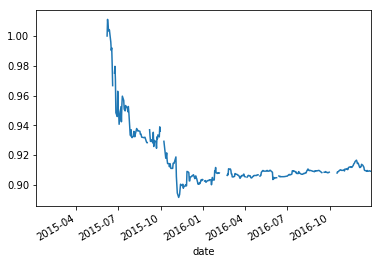

In [27]:
to_index(trade_rets).plot()

In [28]:
# 书里代码不对，用returns的话后面groupby长度不匹配啊。。。
vol = trade_rets.rolling(window=250, min_periods=200).std() * np.sqrt(250)

In [29]:
def sharpe(rets, ann=250): # 计算夏普率，定义自己网上查
  return rets.mean() / rets.std()  * np.sqrt(ann)

In [30]:
trade_rets.groupby(pd.qcut(vol, 4)).agg(sharpe)

close
(0.0161, 0.0232]   -0.339051
(0.0232, 0.0401]    0.682121
(0.0401, 0.0521]    2.242032
(0.0521, 0.0715]   -0.146591
Name: close, dtype: float64